## Training

based on https://github.com/ShinyQ/Thesis_University-Feedback-Sentiment-Model_IndoBERT/blob/main/IndoBERT%20Classification%20Training.ipynb

In [1]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification
from transformers import Trainer
#from datasets import load_metric

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

c:\Users\Revalda Putawara\.conda\envs\mbgsentiment\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv(r"dataset/processed/processed_data_sentiment.csv")
df = df[['text_cleaned_stemmed', 'mdhugol_sentiment']]
df.rename(columns={"text_cleaned_stemmed": "text", "mdhugol_sentiment": "label"}, inplace=True)

In [3]:
df = df[['text', 'label']]
df.sample(5)

,text,label
143,tuju sih sama program mbg presiden tapi dng ad...,negative
2116,yang prioritas utama nih buat ngenyangin koali...,positive
3989,dorong ekonomi makanbergizigratis kolaborasi d...,neutral
159,kalau pikir bocil yang dpt mbg malah kek jadi ...,negative
2135,sudah duga selain masalah kurang jatah mbg mas...,negative


In [ ]:
plt.figure(figsize=(5, 5))
sns.countplot(x=df['text'])
plt.show()

In [4]:
df["label"] = df["label"].map({"negative": 0, "neutral": 1, "positive": 2})

In [5]:
RANDOM_SEED = 241

df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    random_state=RANDOM_SEED,
)

df_val, df_test = train_test_split(
    df_test,
    test_size=0.1,
    random_state=RANDOM_SEED,
)

In [ ]:
plt.figure(figsize=(5, 5))
sns.countplot(x=df_train['label'])
plt.show()

In [ ]:
plt.figure(figsize=(5, 5))
sns.countplot(x=df_val['label'])
plt.show()

In [ ]:
plt.figure(figsize=(5, 5))
sns.countplot(x=df_test['label'])
plt.show()

In [6]:
print(f'Total Train: {len(df_train)}')
print(f'Total Val  : {len(df_val)}')
print(f'Total Test : {len(df_test)}')

Total Train: 3773
Total Val  : 849
Total Test : 95


In [7]:
actual_label = df_test['label']

In [8]:
df_train.to_csv(r"dataset/train/train.csv", index=False)
df_val.to_csv(r"dataset/train/eval.csv", index=False)
df_test.to_csv(r"dataset/train/test.csv", index=False)

In [9]:
from datasets import load_dataset

files = {
    "train": r"dataset/train/train.csv", 
    "eval": r"dataset/train/eval.csv", 
    "test": r"dataset/train/test.csv",
}

dataset = load_dataset('csv', data_files=files)

Generating train split: 3773 examples [00:00, 96910.57 examples/s]
Generating eval split: 849 examples [00:00, 71101.25 examples/s]
Generating test split: 95 examples [00:00, 19914.98 examples/s]


## Tokenize Model

In [10]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p2")

In [11]:
df.head()

,text,label
0,ketua umum pdip megawati soekarnoputri sempat ...,1
1,hold wowo dapat airdrop makansianggratis,2
2,kalau mbg nya ini gue juga mau dut biar gue mu...,0
3,program mbg tuh b nya syukur bukan gizi,0
4,enggak semua anak indonesia bisa makan siang i...,0


In [12]:
def tokenize_function(text):
    return tokenizer(text["text"], padding='max_length', max_length=256)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map: 100%|██████████| 95/95 [00:00<00:00, 1537.69 examples/s]


In [13]:
train_dataset = tokenized_datasets["train"]
eval_dataset = tokenized_datasets["eval"]

## Train Model

In [14]:
import torch
torch.cuda.empty_cache()

In [15]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [16]:
model = AutoModelForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p2", num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
from transformers import TrainingArguments

In [18]:
training_args = TrainingArguments(
    "test_trainer", 
    per_device_train_batch_size=4,
    num_train_epochs=1
)

In [19]:
import evaluate

In [20]:
accuracy = evaluate.load("accuracy")

In [21]:
#metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    return accuracy.compute(predictions=predictions, references=labels)


In [22]:
f1_metric = evaluate.load("f1")

def compute_f1(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    return f1_metric.compute(predictions=predictions, references=labels)


In [23]:
eval_dataset

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 849
})

In [24]:
torch.cuda.empty_cache()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

training_history = trainer.train()

Step,Training Loss
500,0.859700
1000,0.820900
1500,0.845500
2000,0.743100
2500,0.730600
3000,0.757200
3500,0.809800
4000,0.700200
4500,0.651600
5000,0.732900


In [45]:
trainer.state.log_history

[{'loss': 0.8597,
  'grad_norm': 13.820110321044922,
  'learning_rate': 4.735169491525424e-05,
  'epoch': 0.5296610169491526,
  'step': 500},
 {'loss': 0.8209,
  'grad_norm': 9.233704566955566,
  'learning_rate': 4.470338983050847e-05,
  'epoch': 1.0593220338983051,
  'step': 1000},
 {'loss': 0.8455,
  'grad_norm': 2.6593785285949707,
  'learning_rate': 4.205508474576271e-05,
  'epoch': 1.5889830508474576,
  'step': 1500},
 {'loss': 0.7431,
  'grad_norm': 207.6713409423828,
  'learning_rate': 3.940677966101695e-05,
  'epoch': 2.1186440677966103,
  'step': 2000},
 {'loss': 0.7306,
  'grad_norm': 3.038663864135742,
  'learning_rate': 3.675847457627119e-05,
  'epoch': 2.648305084745763,
  'step': 2500},
 {'loss': 0.7572,
  'grad_norm': 0.529522716999054,
  'learning_rate': 3.4110169491525426e-05,
  'epoch': 3.1779661016949152,
  'step': 3000},
 {'loss': 0.8098,
  'grad_norm': 37.2795524597168,
  'learning_rate': 3.1461864406779664e-05,
  'epoch': 3.707627118644068,
  'step': 3500},
 {'los

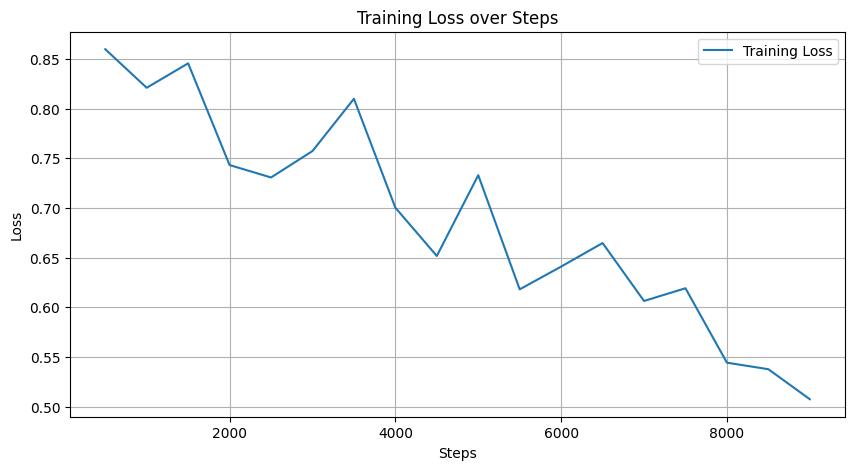

In [48]:
steps = []
losses = []

for log in trainer.state.log_history:
    if "loss" in log: 
        steps.append(log["step"])
        losses.append(log["loss"])

plt.figure(figsize=(10, 5))
plt.plot(steps, losses, label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss over Steps")
plt.legend()
plt.grid()
plt.show()

In [47]:
evaluation_history = trainer.evaluate()
evaluation_history

{'eval_loss': 0.9835682511329651,
 'eval_accuracy': 0.7809187279151943,
 'eval_runtime': 20.8893,
 'eval_samples_per_second': 40.643,
 'eval_steps_per_second': 5.122,
 'epoch': 10.0}

In [27]:
test_dataset = tokenized_datasets["test"]

prediction = trainer.predict(test_dataset)
prediction = prediction.predictions.argmax(1)

In [28]:
print(classification_report(prediction, actual_label, target_names=["Negatif", "Netral", "Positif"]))

              precision    recall  f1-score   support

     Negatif       0.93      0.89      0.91        44
      Netral       0.56      0.78      0.65        18
     Positif       0.89      0.76      0.82        33

    accuracy                           0.82        95
   macro avg       0.79      0.81      0.79        95
weighted avg       0.85      0.82      0.83        95



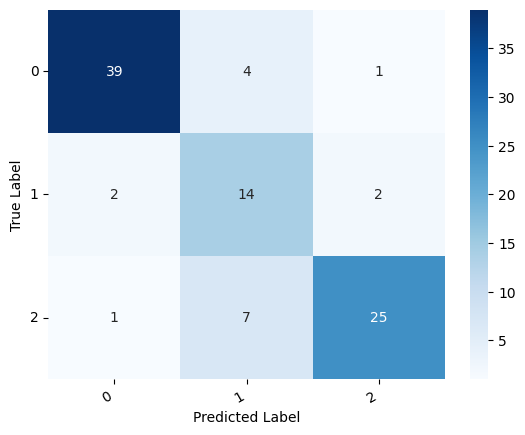

In [29]:
def show_confusion_matrix(confusion_matrix):
        hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
        hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
        hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')

        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')

cm = confusion_matrix(prediction, actual_label)
show_confusion_matrix(cm)

In [49]:
model.save_pretrained("model")

In [31]:
#one of [None, 'micro', 'macro', 'weighted']
f1_metric.compute(predictions=prediction, references=actual_label, average="weighted")

{'f1': 0.8139253967935469}